# 聊天记录综合分析报告

本项目旨在对微信聊天记录进行深入分析。通过利用 Python 的数据分析和可视化库，我们将从多个维度探索聊天数据，包括消息活跃度、发言习惯、关键词云、情绪变化趋势以及消息类型分布等。

分析流程如下：
1.  **环境设置与数据准备**：配置必要的库和字体，加载并清洗数据。
2.  **基本统计**：分析总体消息量、各成员发言量等。
3.  **活跃度分析**：探究在不同时间尺度（按天、按小时）下的消息频率。
4.  **文本内容分析**：通过词云图展示高频词汇。
5.  **情绪分析**：利用 `PaddleHub` 的预训练模型分析消息的情绪倾向，并可视化情绪随时间的变化。
6.  **消息类型分析**：统计不同消息类型（文本、图片、表情包等）的分布情况。

## 1. 环境设置与数据准备

在这一步，我们将安装并导入所有分析所需的库，配置Matplotlib以正确显示中文，然后加载并预处理我们的聊天数据。

开始配置中文字体...
中文字体'SimHei'设置成功。


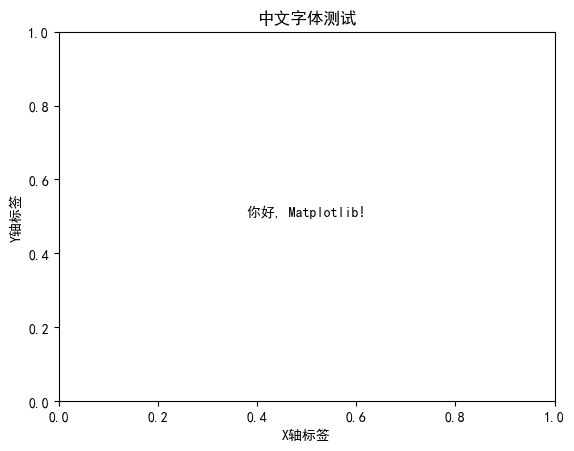

字体测试图表已生成。

所有库导入完毕，字体配置完成。


In [ ]:
# -*- coding: utf-8 -*-
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import jieba

from collections import Counter
import re
import requests # 用于AI报告
from pyecharts.charts import Calendar # 用于热力图
from pyecharts import options as opts # 用于热力图


# 2. 配置Matplotlib中文显示
def setup_chinese_font():
    """
    一个健壮的函数，用于配置Matplotlib中文显示。
    它会尝试找到系统中的'SimHei'字体，如果找不到，会提示用户。
    """
    print("开始配置中文字体...")
    try:
        # 设置字体为 'SimHei'
        plt.rcParams['font.sans-serif'] = ['SimHei']
        # 解决负号'-'显示为方块的问题
        plt.rcParams['axes.unicode_minus'] = False
        print("中文字体'SimHei'设置成功。")
        # 创建一个简单的图形来测试字体是否生效
        fig, ax = plt.subplots()
        ax.set_title("中文字体测试")
        ax.set_xlabel("X轴标签")
        ax.set_ylabel("Y轴标签")
        ax.text(0.5, 0.5, '你好, Matplotlib!', ha='center')
        plt.show()
        print("字体测试图表已生成。")
    except Exception as e:
        print(f"设置中文字体时出错: {e}")
        print("请确保您的系统中已安装'SimHei'字体。")
        print("您也可以修改代码，使用其他已安装的中文字体，例如 'Microsoft YaHei' (微软雅黑)。")

# 执行字体配置
setup_chinese_font()

print("\n所有库导入完毕，字体配置完成。")

In [2]:
# 3. 加载和预处理数据
def load_and_preprocess_data(json_path):
    print(f"开始从 {json_path} 加载数据...")
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"错误：找不到文件 {json_path}。请确保文件名和路径正确。")
        return None
    except json.JSONDecodeError:
        print(f"错误：无法解析 {json_path}。请检查文件格式是否为有效的JSON。")
        return None

    # 处理嵌套的JSON，提取消息列表
    # 如果 'messages' 键存在，则使用其值；否则，假定整个文件就是消息列表
    data = data.get('messages', data)

    # 转换为DataFrame
    df = pd.DataFrame(data)
    print(f"成功加载 {len(df)} 条消息。")

    # --- 数据清洗和特征工程 ---
    rename_map = {
        'formattedTime': 'time',
        'senderDisplayName': 'sender'
    }
    df.rename(columns=rename_map, inplace=True)
    # 转换时间戳
    df['time'] = pd.to_datetime(df['time'])
    
    # 提取日期和小时
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    
    # 提取消息类型
    # 'type' 列可能不存在，使用 .get() 避免错误
    df['message_type'] = df.apply(lambda row: row.get('type', '未知'), axis=1)

    print("数据预处理完成。")
    
    return df

# --- 执行数据加载 ---
# 定义文件路径
JSON_FILE_PATH = 'data.json'

# 加载数据
chat_df = load_and_preprocess_data(JSON_FILE_PATH)

# 显示处理后的数据概览
if chat_df is not None:
    print("\\n--- 数据概览 ---")
    print(chat_df.info())
    print("\\n--- 数据前5行 ---")
    display(chat_df.head())

开始从 data.json 加载数据...
成功加载 9961 条消息。
成功加载 9961 条消息。
数据预处理完成。
\n--- 数据概览 ---
数据预处理完成。
\n--- 数据概览 ---


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9961 entries, 0 to 9960
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   localId         9961 non-null   int64         
 1   createTime      9961 non-null   int64         
 2   time            9961 non-null   datetime64[ns]
 3   type            9961 non-null   object        
 4   localType       9961 non-null   int64         
 5   content         9961 non-null   object        
 6   isSend          9917 non-null   float64       
 7   senderUsername  9961 non-null   object        
 8   sender          9961 non-null   object        
 9   source          9961 non-null   object        
 10  emojiMd5        804 non-null    object        
 11  mediaPath       750 non-null    object        
 12  date            9961 non-null   object        
 13  hour            9961 non-null   int32         
 14  message_type    9961 non-null   object        
dtypes: d

,localId,createTime,time,type,localType,content,isSend,senderUsername,sender,source,emojiMd5,mediaPath,date,hour,message_type
0,1676,1748781754,2025-06-01 20:42:34,通话消息,50,[通话消息],0.0,wxid_2gbxgakagb9422,好友,,NaN,NaN,2025-06-01,20,通话消息
1,1675,1748783847,2025-06-01 21:17:27,图片消息,3,[图片],0.0,wxid_2gbxgakagb9422,好友,<msgsource>\n <bizflag>0</bizflag>\n <se...,NaN,NaN,2025-06-01,21,图片消息
2,1674,1748784165,2025-06-01 21:22:45,动画表情,47,media/emojis/dbd170852355859a8b5f392d03976a4d.png,1.0,wxid_ugq1btskcfyu22,我,<msgsource>\n <signature>N0_V1_aVi9PnOv|v1_...,dbd170852355859a8b5f392d03976a4d,media/emojis/dbd170852355859a8b5f392d03976a4d.png,2025-06-01,21,动画表情
3,1673,1748784169,2025-06-01 21:22:49,动画表情,47,media/emojis/e72a0c8079ae42858b90b8a03adb6e22.jpg,1.0,wxid_ugq1btskcfyu22,我,<msgsource>\n <signature>N0_V1_wBMiCai6|v1_...,e72a0c8079ae42858b90b8a03adb6e22,media/emojis/e72a0c8079ae42858b90b8a03adb6e22.jpg,2025-06-01,21,动画表情
4,1672,1748785678,2025-06-01 21:47:58,文本消息,1,有什么英文文献查重查ai的免费网站吗[流泪],1.0,wxid_ugq1btskcfyu22,我,<msgsource>\n <sec_msg_node>\n <alno...,NaN,NaN,2025-06-01,21,文本消息


## 2. 基本统计分析

在数据准备好之后，我们首先进行一些基本的统计，以了解聊天概况，例如总消息量、每个成员的发言量等。

总消息数: 9961
\n--- 每人发言数量 ---
sender
好友    6204
我     3757
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_31740\814042521.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sender_counts.index, y=sender_counts.values, palette='viridis')


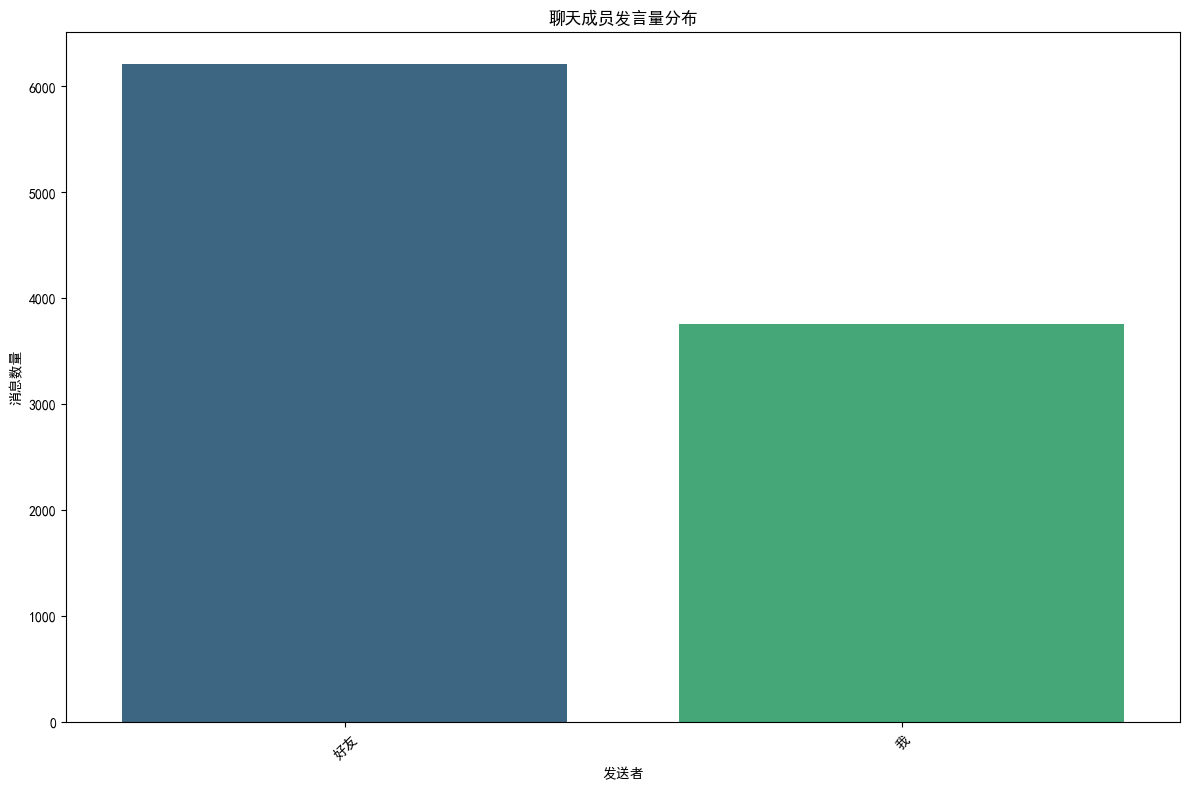

\n--- 消息类型分布 ---
message_type
文本消息                  7760
动画表情                   804
图片消息                   454
引用消息                   406
语音消息                   178
图文消息                    92
聊天记录合并转发                69
卡片式链接                   46
系统消息                    44
文件消息                    27
通话消息                    24
视频消息                    22
转账卡片                    20
位置消息                     4
拍一拍消息                    4
未知类型(219043332145)       2
未知类型(141733920817)       2
红包卡片                     1
小程序分享                    1
未知类型(73014444081)        1
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_31740\814042521.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=message_type_counts.index, y=message_type_counts.values, palette='magma')


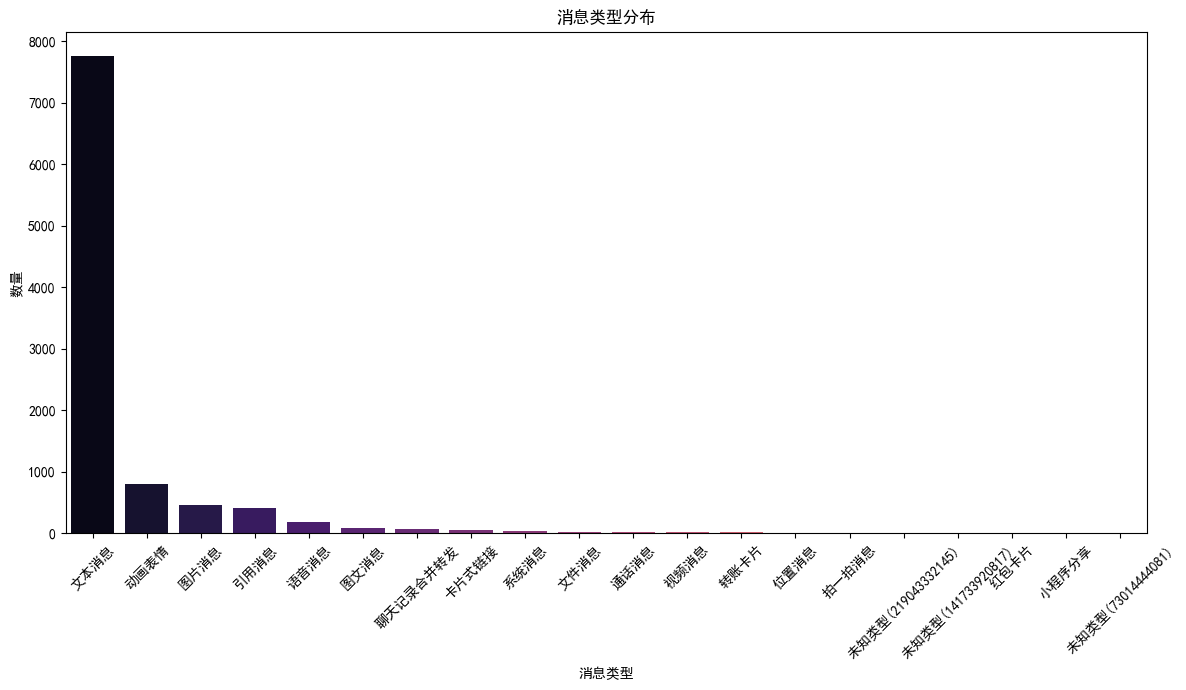

In [3]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 基本统计 ---
    # 计算总消息数
    total_messages = len(chat_df)
    print(f"总消息数: {total_messages}")

    # 计算每个发送者的消息数
    sender_counts = chat_df['sender'].value_counts()
    print("\\n--- 每人发言数量 ---")
    print(sender_counts)

    # 可视化发言人分布
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sender_counts.index, y=sender_counts.values, palette='viridis')
    plt.title('聊天成员发言量分布')
    plt.xlabel('发送者')
    plt.ylabel('消息数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 消息类型分析 (合并) ---
    message_type_counts = chat_df['message_type'].value_counts()
    print("\\n--- 消息类型分布 ---")
    print(message_type_counts)
    
    # 可视化消息类型分布
    plt.figure(figsize=(12, 7))
    sns.barplot(x=message_type_counts.index, y=message_type_counts.values, palette='magma')
    plt.title('消息类型分布')
    plt.xlabel('消息类型')
    plt.ylabel('数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 3. 活跃度分析

本部分将分析聊天活跃度随时间的变化趋势，包括每日消息量和每小时消息分布。

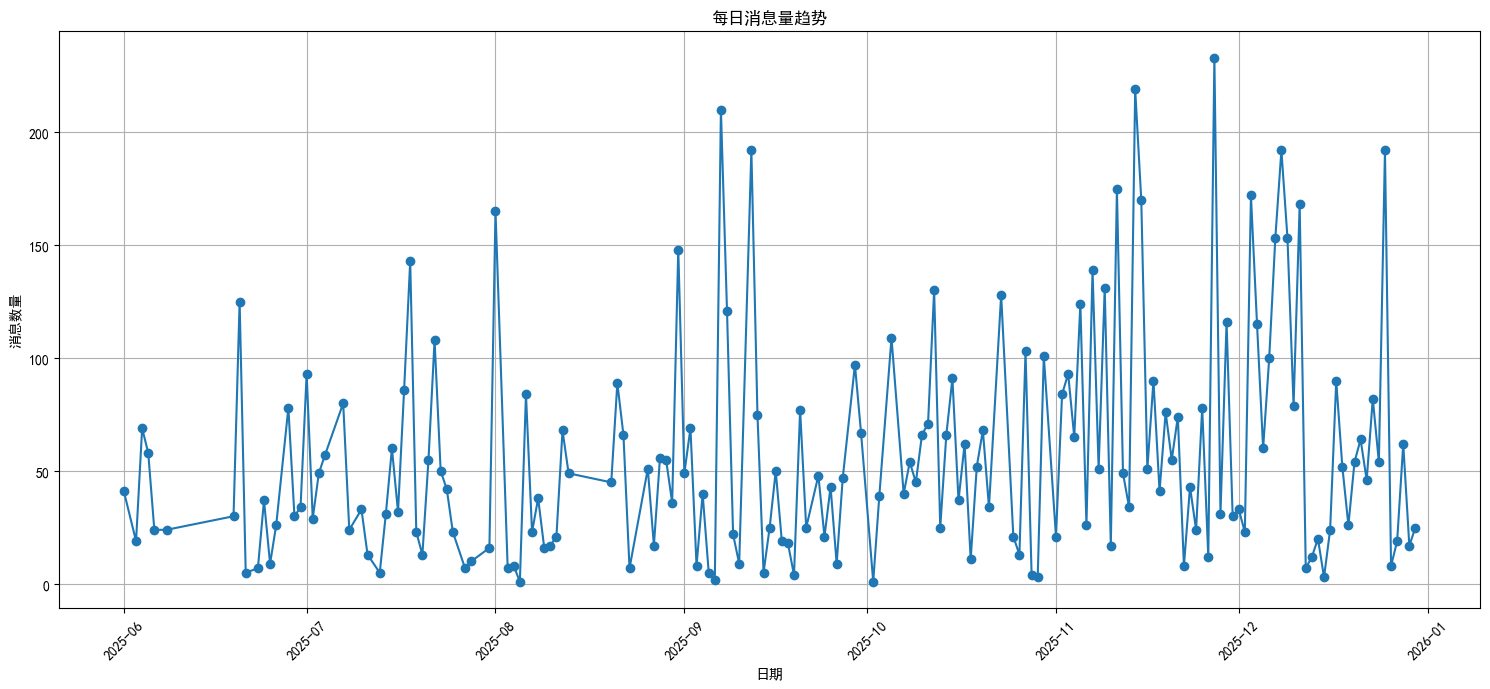

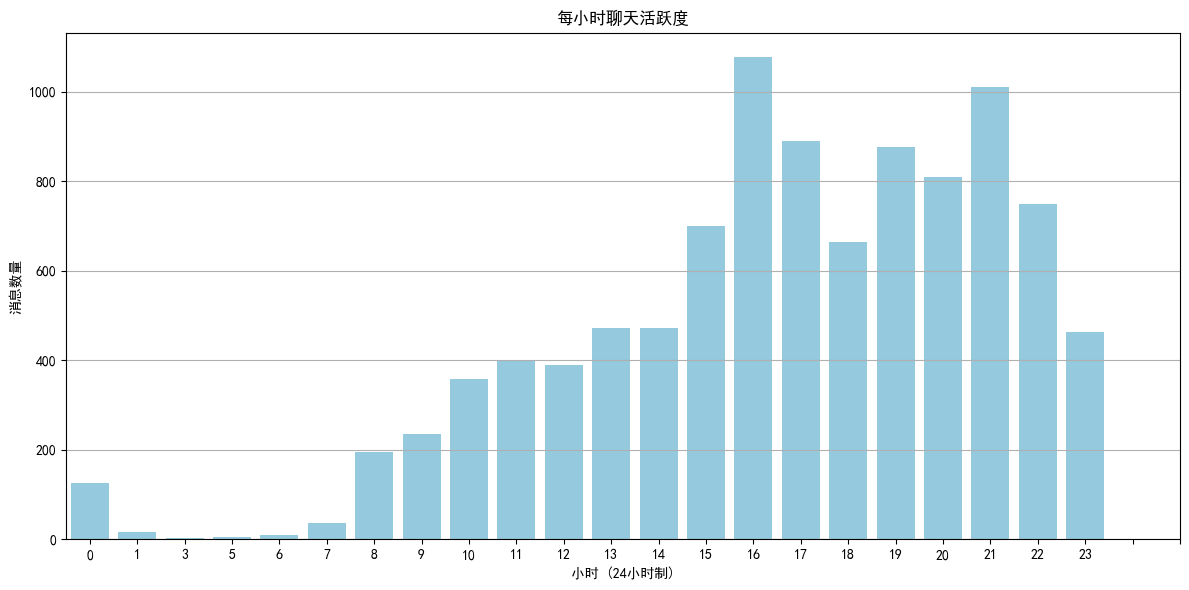

In [4]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 每日消息趋势 ---
    daily_trend = chat_df.groupby('date').size()
    
    plt.figure(figsize=(15, 7))
    daily_trend.plot(kind='line', marker='o', linestyle='-')
    plt.title('每日消息量趋势')
    plt.xlabel('日期')
    plt.ylabel('消息数量')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 每日聊天数量热力图 ---
    # 确保 daily_trend 的索引是 datetime 类型
    daily_trend.index = pd.to_datetime(daily_trend.index)
    date_range = pd.date_range(start=daily_trend.index.min(), end=daily_trend.index.max(), freq='D')
    daily_trend = daily_trend.reindex(date_range, fill_value=0)
    
    data = [[date.strftime('%Y-%m-%d'), count] for date, count in daily_trend.items()]
    
    min_year = daily_trend.index.min().year
    max_year = daily_trend.index.max().year
    
    calendar = (
        Calendar()
        .add("", data, calendar_opts=opts.CalendarOpts(range_=[str(min_year), str(max_year)]))
        .set_global_opts(
            title_opts=opts.TitleOpts(title=f"{min_year}-{max_year} 聊天热力图"),
            visualmap_opts=opts.VisualMapOpts(
                max_=int(daily_trend.max() * 1.1) if daily_trend.max() > 0 else 1, # 避免max为0
                min_=0,
                orient="horizontal",
                is_piecewise=False,
                pos_top="230px",
                pos_left="center",
            ),
        )
    )
    
    # --- 每小时活跃度分布 ---
    hourly_activity = chat_df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=hourly_activity.index, y=hourly_activity.values, color='skyblue')
    plt.title('每小时聊天活跃度')
    plt.xlabel('小时 (24小时制)')
    plt.ylabel('消息数量')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # 将 pyecharts 图表作为单元格的最后输出来渲染
    calendar.render_notebook()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 4. 文本内容分析 (词云)

为了直观地展示聊天中最常讨论的话题，我们创建一个词云。这需要提取所有文本消息，使用`jieba`进行中文分词，并过滤掉常见的停用词。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache


成功从 stop words.txt 加载 4011 个停用词。


Loading model cost 1.344 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


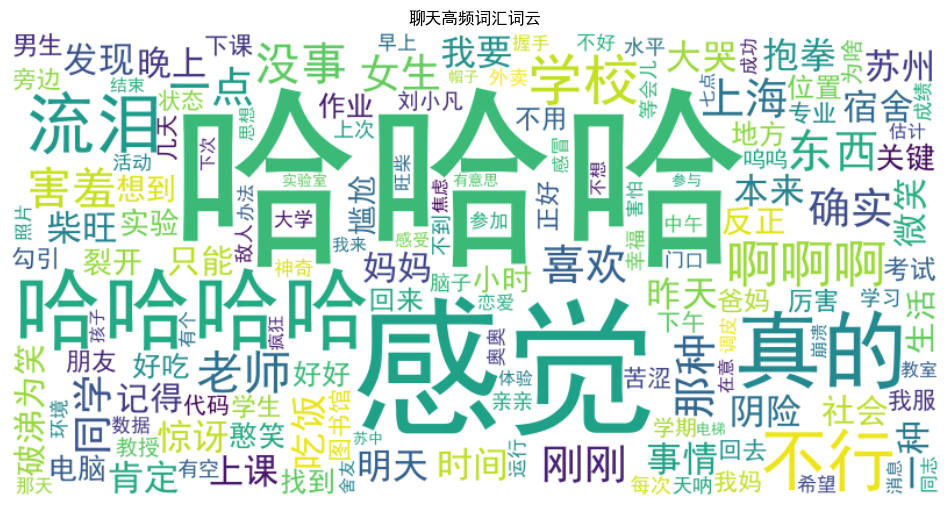

In [5]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 词云生成 ---
    
    # 1. 从文件加载停用词
    def load_stopwords(filepath):
        """从文件加载停用词列表"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                stopwords = {line.strip() for line in f}
            print(f"成功从 {filepath} 加载 {len(stopwords)} 个停用词。")
            # 添加一些默认的、可能缺失的停用词
            stopwords.update(["图片", "表情", "语音", "视频", "文件", "红包", "转账", "链接", "[图片]", "[表情]", "撤回了一条消息", "拍了拍"])
            return stopwords
        except FileNotFoundError:
            print(f"错误：找不到停用词文件 {filepath}。请确保文件存在。")
            return set()

    stopwords_path = 'stop words.txt'
    stopwords = load_stopwords(stopwords_path)

    # 2. 提取所有文本消息
    # 确保只处理 'Text' 类型的消息，并且内容是字符串
    text_messages = chat_df[chat_df['message_type'] == '文本消息']['content'].dropna().astype(str)
    full_text = " ".join(text_messages)

    # 3. 中文分词
    # 使用正则表达式去除所有非中文字符，只保留汉字用于分词
    chinese_only_text = re.sub(r"[^\u4e00-\u9fa5]+", "", full_text)
    words = jieba.cut(chinese_only_text)
    
    # 4. 过滤停用词
    filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
    
    # 5. 检查过滤后是否还有词
    if not filtered_words:
        print("⚠️ 警告：在过滤停用词后，没有剩余的词语可用于生成词云。")
        print("这可能是因为：")
        print("1. 聊天记录中的文本内容过少。")
        print("2. 停用词列表过于宽泛，过滤掉了所有词语。")
        print("请检查您的数据和 'stop words.txt' 文件。")
    else:
        # 6. 生成词云
        word_freq = Counter(filtered_words)
        
        # 选择一个系统中可能存在的中文字体
        font_path = 'C:/Windows/Fonts/simhei.ttf'
        if not os.path.exists(font_path):
            print(f"警告: 找不到字体 {font_path}。词云可能无法正确显示中文。")
            print("请根据您的操作系统修改为正确的字体路径。")
            # 在Windows上，可以尝试 'msyh.ttc' (微软雅黑)
            font_path = 'C:/Windows/Fonts/msyh.ttc' 
            if not os.path.exists(font_path):
                font_path = None # 如果都找不到，则不指定字体路径

        try:
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white',
                font_path=font_path, # 指定中文字体路径
                stopwords=stopwords,
                max_words=150,
                colormap='viridis'
            ).generate_from_frequencies(word_freq)

            plt.figure(figsize=(12, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('聊天高频词汇词云')
            plt.show()
        except Exception as e:
            print(f"生成词云时发生错误: {e}")
            if "font" in str(e).lower():
                print("错误很可能与字体有关。请检查 `font_path` 是否指向一个有效的中文字体文件。")

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 5. 情绪分析

本节利用`PaddleHub`的`ernie_skep_sentiment_analysis`模型对文本消息进行情绪分析。我们将分析整体的情绪分布，并探究情绪随时间的变化趋势。

d:\Anaconda\envs\myenv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
PLEASE USE OMP_NUM_THREADS WISELY.
PLEASE USE OMP_NUM_THREADS WISELY.
d:\Anaconda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\myenv\Lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing dist

PaddleHub ERNIE-SKEP 模型加载成功。
开始对 7760 条文本进行情感分析（ERNIE-SKEP，CPU）...
ERNIE 批次失败（0-8）：(NotFound) OneDnnContext does not have the input W.
  [Hint: Expected it != inputs_name_.end(), but received it == inputs_name_.end().] (at ..\paddle\phi\backends\onednn\onednn_context.cc:345)
  [operator < fc > error]
ERNIE-SKEP 推理失败或返回为空，将切换到备用模型 senta_bilstm。
Download https://bj.bcebos.com/paddlehub/paddlehub_dev/senta_bilstm_1.2.1.tar.gz
Download https://bj.bcebos.com/paddlehub/paddlehub_dev/senta_bilstm_1.2.1.tar.gz
[##################################################] 100.00%
Decompress C:\Users\user\.paddlehub\tmp\tmpa62_fcow\senta_bilstm_1.2.1.tar.gz

Decompress C:\Users\user\.paddlehub\tmp\tmpa62_fcow\senta_bilstm_1.2.1.tar.gz
[##################################################] 100.00%



[2026-01-06 20:02:14,181] [    INFO] - Successfully installed senta_bilstm-1.2.1
[2026-01-06 20:02:14,778] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object
[2026-01-06 20:02:14,778] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


备用模型 senta_bilstm 加载成功。
开始对 7760 条文本进行情感分析（senta_bilstm，CPU）...
Download https://bj.bcebos.com/paddlehub/paddlehub_dev/lac_2.4.0.zip
Download https://bj.bcebos.com/paddlehub/paddlehub_dev/lac_2.4.0.zip
[##################################################] 100.00%
Decompress C:\Users\user\.paddlehub\tmp\tmpdtwr8dld\lac_2.4.0.zip

Decompress C:\Users\user\.paddlehub\tmp\tmpdtwr8dld\lac_2.4.0.zip
[##################################################] 100.00%



[2026-01-06 20:02:34,470] [    INFO] - Successfully installed lac-2.4.0


BiLSTM 批次失败（0-32）：(NotFound) OneDnnContext does not have the input WeightH.
  [Hint: Expected it != inputs_name_.end(), but received it == inputs_name_.end().] (at ..\paddle\phi\backends\onednn\onednn_context.cc:345)
  [operator < fusion_gru > error]
已处理 32/7760...
BiLSTM 批次失败（32-64）：(NotFound) OneDnnContext does not have the input WeightH.
  [Hint: Expected it != inputs_name_.end(), but received it == inputs_name_.end().] (at ..\paddle\phi\backends\onednn\onednn_context.cc:345)
  [operator < fusion_gru > error]
BiLSTM 批次失败（64-96）：(NotFound) OneDnnContext does not have the input WeightH.
  [Hint: Expected it != inputs_name_.end(), but received it == inputs_name_.end().] (at ..\paddle\phi\backends\onednn\onednn_context.cc:345)
  [operator < fusion_gru > error]
BiLSTM 批次失败（96-128）：(NotFound) OneDnnContext does not have the input WeightH.
  [Hint: Expected it != inputs_name_.end(), but received it == inputs_name_.end().] (at ..\paddle\phi\backends\onednn\onednn_context.cc:345)
  [operator

,content,date,hour,positive_prob,sentiment
0,有什么英文文献查重查ai的免费网站吗[流泪],2025-06-01,21,0.501261,中性
1,你自己论文查重吗,2025-06-01,21,0.205985,消极
2,啊啊啊我们提交作业平台上一个内置的查重软件,2025-06-01,21,0.251719,消极
3,其他基本都要钱,2025-06-01,21,0.320610,消极
4,你这个很重要的话建议花15块查一下,2025-06-01,21,0.295533,消极


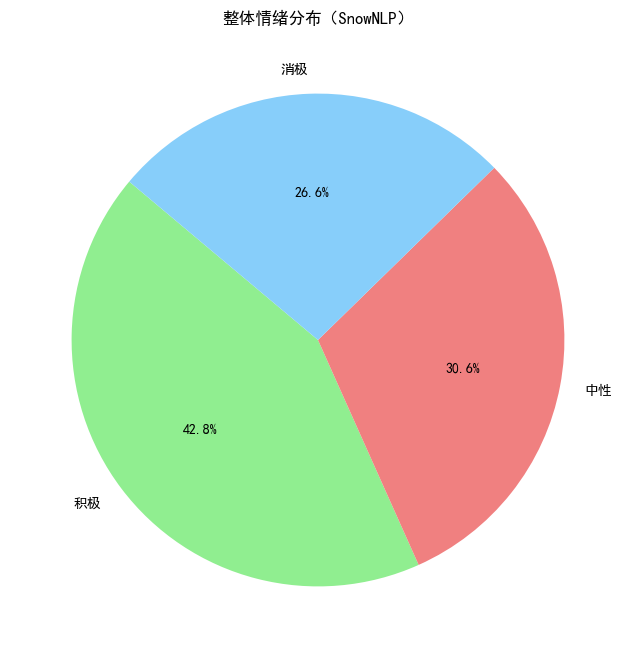

SnowNLP 也失败：category dtype does not support aggregation 'mean'


In [ ]:
os.environ['FLAGS_use_mkldnn'] = '0'
os.environ['OMP_NUM_THREADS'] = '1'
if 'chat_df' in locals() and chat_df is not None:
    # --- 情绪分析（优先：PaddleHub ERNIE-SKEP；回退：senta_bilstm -> SnowNLP） ---
    import os as _os, sys as _sys

    # 1) 准备文本数据
    text_df = chat_df[chat_df['message_type'] == '文本消息'][['content', 'date', 'hour']].copy()
    text_df.dropna(subset=['content'], inplace=True)
    text_df.reset_index(drop=True, inplace=True)
    text_list = text_df['content'].astype(str).tolist()

    def post_process_and_plot(_df, _results, label_key='sentiment_label', pos_key='positive_probs'):
        if not _results:
            print("❌ 情感分析结果为空，跳过可视化。")
            return
        if len(_results) != len(_df):
            print(f"⚠️ 仅成功 {len(_results)}/{len(_df)} 条，将按成功数量对齐。")
            _df = _df.iloc[:len(_results)].copy()
        _df['sentiment_label'] = [r.get(label_key, r.get('label')) for r in _results]
        _df['positive_prob'] = [r.get(pos_key, r.get('positive_prob', r.get('prob', None))) for r in _results]
        # 标签映射（兼容 0/1 与英文标签）
        sentiment_map = {'positive': '积极', 'negative': '消极', 'neutral': '中性', '1': '积极', '0': '消极', 1: '积极', 0: '消极'}
        _df['sentiment'] = _df['sentiment_label'].map(sentiment_map).fillna('未知')

        print("情感分析完成。样例：")
        display(_df.head())

        # 整体分布
        sentiment_counts = _df['sentiment'].value_counts()
        plt.figure(figsize=(8, 8))
        plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140,
                colors=['lightgreen', 'lightcoral', 'lightskyblue'])
        plt.title('整体情绪分布')
        plt.ylabel('')
        plt.show()

        # 时间趋势（按天）
        sentiment_score_map = {'积极': 1, '消极': -1, '中性': 0}
        _df['sentiment_score'] = _df['sentiment'].map(sentiment_score_map)
        daily_sentiment = _df.groupby('date')['sentiment_score'].mean()

        plt.figure(figsize=(15, 7))
        daily_sentiment.plot(kind='line', color='purple')
        plt.axhline(0, color='grey', linestyle='--')
        plt.title('每日平均情绪得分趋势')
        plt.xlabel('日期')
        plt.ylabel('平均情绪得分 (积极 > 0, 消极 < 0)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    results = None

    # 2) 首选方案：仅在 paddle 未被提前导入的情况下尝试 ERNIE-SKEP
    if not already_imported_paddle:
        try:
            import paddle
            # 再次以代码方式关闭 MKLDNN（双保险）
            try:
                paddle.set_flags({'FLAGS_use_mkldnn': False})
            except Exception:
                pass
            paddle.set_device('cpu')

            import paddlehub as hub
            senta = hub.Module(name="ernie_skep_sentiment_analysis")
            print("PaddleHub ERNIE-SKEP 模型加载成功。")

            batch_size = 8  # 进一步减小批大小
            results = []
            print(f"开始对 {len(text_list)} 条文本进行情感分析（ERNIE-SKEP，CPU）...")
            onednn_error = False
            for i in range(0, len(text_list), batch_size):
                batch = text_list[i:i+batch_size]
                try:
                    res = senta.predict_sentiment(batch, use_gpu=False)
                except Exception as e:
                    print(f"ERNIE 批次失败（{i}-{i+len(batch)}）：{e}")
                    if 'OneDnnContext' in str(e) or 'onednn' in str(e).lower():
                        onednn_error = True
                        break
                    res = []
                results.extend(res)
                if (i // batch_size) % 20 == 0 or i + batch_size >= len(text_list):
                    print(f"已处理 {min(i + batch_size, len(text_list))}/{len(text_list)}...")

            if onednn_error or len(results) == 0:
                print("ERNIE-SKEP 推理失败或返回为空，将切换到备用模型 senta_bilstm。")
                results = None
            else:
                post_process_and_plot(text_df, results)
        except Exception as e:
            print(f"ERNIE-SKEP 路径不可用：{e}")
            results = None

    # 3) 备用方案1：PaddleHub senta_bilstm（静态图经典模型，通常更稳）
    if results is None:
        try:
            import paddlehub as hub
            bilstm = hub.Module(name='senta_bilstm')
            print("备用模型 senta_bilstm 加载成功。")
            batch_size = 32
            results = []
            print(f"开始对 {len(text_list)} 条文本进行情感分析（senta_bilstm，CPU）...")
            for i in range(0, len(text_list), batch_size):
                batch = text_list[i:i+batch_size]
                try:
                    # 不同Hub版本的参数名可能不同，兼容处理
                    try:
                        res = bilstm.sentiment_classify(texts=batch, use_gpu=False)
                    except TypeError:
                        res = bilstm.sentiment_classify(batch)
                except Exception as e:
                    print(f"BiLSTM 批次失败（{i}-{i+len(batch)}）：{e}")
                    res = []
                results.extend(res)
                if (i // batch_size) % 20 == 0 or i + batch_size >= len(text_list):
                    print(f"已处理 {min(i + batch_size, len(text_list))}/{len(text_list)}...")

            if len(results) == 0:
                print("senta_bilstm 推理失败或返回为空，将切换到 SnowNLP。")
                results = None
            else:
                post_process_and_plot(text_df, results, label_key='sentiment_label', pos_key='positive_probs')
        except Exception as e:
            print(f"senta_bilstm 备用路径失败：{e}")
            results = None

    # 4) 备用方案2：SnowNLP（纯Python，速度快，效果一般）
    if results is None:
        print("切换到超轻量级备用方案 SnowNLP …")
        try:
            try:
                from snownlp import SnowNLP
            except ImportError:
                import subprocess
                print("正在安装 snownlp …")
                subprocess.check_call([_sys.executable, '-m', 'pip', 'install', '-i', 'https://pypi.tuna.tsinghua.edu.cn/simple', 'snownlp'])
                from snownlp import SnowNLP

            scores = []
            for i, t in enumerate(text_list):
                try:
                    s = SnowNLP(t).sentiments  # 0~1
                except Exception:
                    s = 0.5
                scores.append(float(s))
                if (i + 1) % 500 == 0 or i + 1 == len(text_list):
                    print(f"已处理 {i + 1}/{len(text_list)} …")

            text_df['positive_prob'] = scores
            text_df['sentiment'] = pd.cut(text_df['positive_prob'], bins=[0, 0.4, 0.6, 1.0], labels=['消极', '中性', '积极'], include_lowest=True)

            print("SnowNLP 情感分析完成。样例：")
            display(text_df.head())

            # 整体分布
            sentiment_counts = text_df['sentiment'].value_counts()
            plt.figure(figsize=(8, 8))
            plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140,
                    colors=['lightgreen', 'lightcoral', 'lightskyblue'])
            plt.title('整体情绪分布（SnowNLP）')
            plt.ylabel('')
            plt.show()

            # 时间趋势（按天）
            sentiment_score_map = {'积极': 1, '消极': -1, '中性': 0}
            text_df['sentiment_score'] = text_df['sentiment'].map(sentiment_score_map)
            daily_sentiment = text_df.groupby('date')['sentiment_score'].mean()

            plt.figure(figsize=(15, 7))
            daily_sentiment.plot(kind='line', color='purple')
            plt.axhline(0, color='grey', linestyle='--')
            plt.title('每日平均情绪得分趋势（SnowNLP）')
            plt.xlabel('日期')
            plt.ylabel('平均情绪得分 (积极 > 0, 消极 < 0)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"SnowNLP 也失败：{e}")
else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 7. AI 生成的分析报告 (DeepSeek)

本部分将利用 `chat_analyzer.py` 中的功能，调用外部的 AI 模型（如 DeepSeek）来生成一份关于聊天内容的摘要和分析报告。这可以提供一个更宏观、更具洞察力的视角。

In [7]:
def generate_ai_report(api_key, chat_dataframe, top_n=10):
    """
    使用DeepSeek API生成聊天记录的AI分析报告。
    
    Args:
        api_key (str): DeepSeek API密钥。
        chat_dataframe (pd.DataFrame): 包含聊天记录的DataFrame。
        top_n (int): 用于分析的最高频词数量。
    """
    if not api_key or api_key == "YOUR_DEEPSEEK_API_KEY":
        print("⚠️ 警告：未提供有效的DeepSeek API Key。跳过AI报告生成。")
        print("请访问 https://platform.deepseek.com/api_keys 获取您的密钥。")
        return

    print("\\n" + "="*60)
    print("🤖 正在生成AI分析报告 (Powered by DeepSeek)...")
    print("="*60)

    # 1. 准备报告所需的数据
    total_messages = len(chat_dataframe)
    duration_days = (chat_dataframe['date'].max() - chat_dataframe['date'].min()).days
    sender_counts = chat_dataframe['sender'].value_counts()
    
    # 准备文本内容进行分词
    text_content = " ".join(chat_dataframe[chat_dataframe['message_type'] == 'Text']['content'].dropna().astype(str))
    words = [word for word in jieba.cut(text_content) if len(word) > 1 and word not in stopwords]
    top_words = Counter(words).most_common(top_n)

    # 2. 构建Prompt
    prompt = f"""
    请根据以下聊天数据摘要，生成一份简短、深刻的中文分析报告。报告应包括：
    1.  对整体聊天风格和氛围的总结。
    2.  对主要参与者的沟通模式的简要分析。
    3.  基于高频词汇，推断出他们可能的核心话题或关系特点。
    4.  提出一两个有趣的观察或结论。

    **数据摘要:**
    - **时间跨度**: {duration_days} 天
    - **总消息数**: {total_messages} 条
    - **参与者消息分布**:
"""
    for sender, count in sender_counts.items():
        prompt += f"      - {sender}: {count} 条 ({count/total_messages:.1%})\\n"
    
    prompt += f"- **讨论的 Top {top_n} 高频词汇**: {', '.join([word for word, count in top_words])}\\n"

    prompt += "\n**分析报告:**\n"

    # 3. 调用API
    try:
        url = "https://api.deepseek.com/chat/completions"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": "你是一位精通社会学和心理学的数据分析师，擅长从沟通数据中发现深层关系和模式。"},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.7,
            "stream": False
        }
        
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status() # 如果请求失败则抛出异常
        
        result = response.json()
        report_content = result['choices'][0]['message']['content']
        
        print("--- AI 分析报告 ---")
        print(report_content)
        print("--------------------")

    except requests.exceptions.RequestException as e:
        print(f"❌ 调用AI报告API时出错: {e}")
    except (KeyError, IndexError):
        print("❌ 解析AI报告API响应时出错，请检查返回的数据格式。")


# --- 执行AI报告生成 ---
# 读取配置中的DeepSeek API Key
try:
    from config import DEEPSEEK_API_KEY
    api_key = DEEPSEEK_API_KEY
except:
    api_key = None

if 'chat_df' in locals() and chat_df is not None:
    generate_ai_report(api_key, chat_df)
else:
    print("数据未成功加载，请先执行AI报告生成步骤。")

\n============================================================
🤖 正在生成AI分析报告 (Powered by DeepSeek)...
--- AI 分析报告 ---
### 聊天数据分析报告

#### 1. 整体聊天风格与氛围
在长达212天的持续互动中，两位参与者共交换了近万条消息，显示出**高度活跃且稳定的沟通关系**。整体氛围呈现出**亲密、轻松且高度分享性**的特点。对话节奏快、密度高，表明双方有强烈的日常交流意愿，聊天已成为彼此生活中一个重要的情感与信息交换渠道。

#### 2. 主要参与者的沟通模式
- **好友**：作为对话的主导方（占比62.3%），好友表现出更强的**倾诉欲和话题发起倾向**。其沟通模式可能更偏向于情感表达、事件分享或寻求互动反馈，在关系中可能承担了更多“讲述者”或“情绪带动者”的角色。
- **我**：虽然消息量较少（37.7%），但能维持近40%的参与度，说明回应积极且持续。沟通模式可能更侧重于**倾听、回应、提问或提供情感支持**，在对话中起到平衡、承接和深化的作用。两者形成了**互补而非对等的交流节奏**。

#### 3. 高频词汇与核心话题/关系推断
高频词汇如“哈哈”、“笑死”、“确实”、“好家伙”、“救命”等，强烈指向以下几个特点：
- **情感共鸣优先**：对话充满轻松、幽默的日常调侃与情绪即时反应，娱乐化和情感共鸣是核心。
- **共享的“内部语境”**：词汇如“那个”、“然后”、“就是”等填充词和承接词多，说明双方有高度默契的对话语境，可能基于共同经历、圈子或习惯用语。
- **关系属性**：高频词中缺乏明显的冲突、正式事务或深度议题词汇，更多是**朋友间的日常陪伴、情绪同步与休闲社交**。关系很可能建立在信任、轻松感和共享的娱乐精神之上，而非功利性或事务性合作。

#### 4. 有趣的观察与结论
- **“高情绪带宽”的友谊**：对话看似碎片化，但通过密集的情绪符号（如“哈哈”、“救命”）和即时反应，构建了一种**持续的情绪陪伴**。这种沟通不一定需要深刻内容，却有效维持了关系的热度和存在感，符合当代亲密友谊的“轻量但高频”特质。
- **沉默的协调者**：尽管“我”的消息量较少，但能长期维持这样的对话平衡，可能意味着**好友更需要这个